In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#train_validate_test_split
def train_valid_test_split(X, y, split_size= (0.7, 0.15, 0.15)):
    loc_1 = round(len(X) * split_size[0])
    loc_2 = round(len(X) * (1-split_size[2]))
    X_train = X[:loc_1]
    X_valid = X[loc_1:loc_2]
    X_test = X[loc_2:]
    y_train = y[:loc_1]
    y_valid = y[loc_1:loc_2]
    y_test = y[loc_2:]
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [13]:
#re-arrange data into multiple batch based on timestep size
def timestep_batch(X, y, timestep):
    X_data = []
    y_data = []
    for i in range(timestep, len(X)):
        X_data.append(X[i-timestep : i])
        y_data.append(y[i])
    
    X_data = torch.DoubleTensor(X_data)
    y_data = torch.DoubleTensor(y_data)
    return X_data, y_data

In [30]:
def callback(model, optim, epoch, loss, valid_loss):
    checkpoint = {
        'epoch': epoch+1,
        'loss': loss,
        'valid_loss': valid_loss,
        'param': model.state_dict(),
        'optim': optim.state_dict()
    }
    return checkpoint

In [76]:
def fit_lstm(X_train_data, y_train_data, X_valid_data, y_valid_data,
             num_layer, batch_size, hidden_size,
             lstm, loss_fn, optimizer,
             num_epoch, start_epoch=0):
    
    train_hist = []
    end_epoch = start_epoch + num_epoch
    
    for epoch in range(start_epoch, end_epoch):
        #initialize hidden and cell state of lstm to zeros tensor
        state_in = (torch.zeros(num_layer, batch_size, hidden_size).double(),
                    torch.zeros(num_layer, batch_size, hidden_size).double()
                   )
    
        #training
        for i in range(X_train_data.size(0)):
            inputs = X_train_data[i].view(1,timestep,1)
            targets = y_train_data[i]
            #forward propagation
            output, _ = lstm.forward(inputs.double(), state_in)
            #calculate Loss
            loss = loss_fn(output.view(1), targets.view(1))
            #backpropagation
            optimizer.zero_grad()
            loss.backward()
            #weight update
            optimizer.step()

        #validating
        lstm.eval()
        for i in range(X_valid_data.size(0)):
            inputs = X_valid_data[i].view(1,timestep,1)
            targets = y_valid_data[i]
            output, _ = lstm.forward(inputs.double(), state_in)
            valid_loss = loss_fn(output.view(1), targets.view(1))

        train_hist.append(callback(lstm, optimizer, epoch, loss, valid_loss))
        print('Epoch: [{}/{}]\t\t Loss: {:.4f}\t\tValidation Loss: {:.4f}'
              .format(epoch+1, end_epoch, loss, valid_loss))
        
    return train_hist

In [17]:
#define model class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layer, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer, batch_first= True) #lstm layer
        self.linear = nn.Linear(hidden_size, output_size) #output layer
        
    def forward(self, X, state_in):
        out, state_out = self.lstm(X, state_in)
        out = self.linear(out[:,-1,:])
        return out, state_out

In [2]:
#import data from yahoo finance via pandas_datareader
df = web.DataReader('AOT.BK', data_source= 'yahoo', end='2021-07-31')
df = df.drop(['Close'], axis= 1)

In [3]:
df

,High,Low,Open,Volume,Adj Close
Date,,,,,
2016-08-23,40.599998,39.900002,40.000000,19818000.0,37.950100
2016-08-24,40.799999,40.200001,40.400002,14772000.0,37.950100
2016-08-25,41.200001,39.900002,40.400002,29142000.0,38.510941
2016-08-26,41.000000,40.400002,40.799999,18367000.0,37.950100
2016-08-29,40.799999,40.000000,40.799999,14759000.0,37.950100
...,...,...,...,...,...
2021-07-22,59.000000,58.000000,58.750000,8649800.0,58.250000
2021-07-23,58.750000,57.750000,58.250000,7064200.0,58.250000
2021-07-27,59.500000,58.250000,58.750000,18468100.0,58.750000


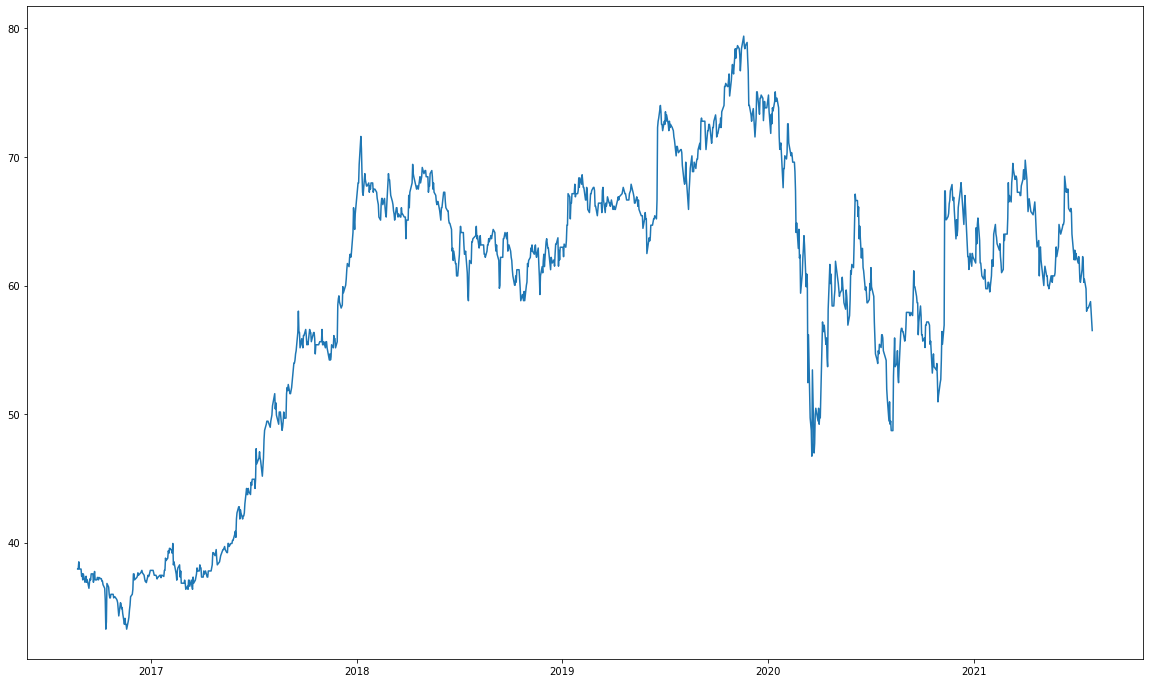

In [4]:
#visualize close price
plt.figure(figsize = (20,12))
plt.plot(df['Adj Close'])

In [5]:
X = df.iloc[:,-1].values
y = df.iloc[:,-1].values

In [7]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, split_size= (0.7, 0.15, 0.15))

In [ ]:
# #standardize the data
# from sklearn.preprocessing import StandardScaler
# X_scaler = StandardScaler()
# X_train = X_scaler.fit_transform(X_train.reshape(-1,1))
# X_valid = X_scaler.transform(X_valid.reshape(-1,1))
# X_test = X_scaler.transform(X_test.reshape(-1,1))

# y_scaler = StandardScaler()
# y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
# y_valid = y_scaler.transform(y_valid.reshape(-1,1))
# y_test = y_scaler.transform(y_test.reshape(-1,1))

In [8]:
#define params
input_size = 1 #num of features
hidden_size = 50 
num_layer = 2 #num of LSTM layers
output_size = 1 #predicting 1 data point at a time
batch_size = 1
num_epoch = 100
timestep = 30

In [14]:
X_train_data, y_train_data = timestep_batch(X_train, y_train, timestep)

In [16]:
X_valid_data, y_valid_data = timestep_batch_batch(X_valid, y_valid, timestep)

In [57]:
#define model object
lstm = LSTM(input_size, hidden_size, num_layer, output_size).double()
lstm

LSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [58]:
#define loss_fn
loss_fn = nn.L1Loss()
loss_fn

L1Loss()

In [59]:
#define optimizer
optimizer = torch.optim.Adam(lstm.parameters(), lr= 0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [60]:
for name, param in lstm.named_parameters():
    print('name: ', name)
    print(type(param))
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print('=====')

name:  lstm.weight_ih_l0
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([200, 1])
param.requires_grad:  True
=====
name:  lstm.weight_hh_l0
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([200, 50])
param.requires_grad:  True
=====
name:  lstm.bias_ih_l0
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([200])
param.requires_grad:  True
=====
name:  lstm.bias_hh_l0
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([200])
param.requires_grad:  True
=====
name:  lstm.weight_ih_l1
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([200, 50])
param.requires_grad:  True
=====
name:  lstm.weight_hh_l1
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([200, 50])
param.requires_grad:  True
=====
name:  lstm.bias_ih_l1
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([200])
param.requires_grad:  True
=====
name:  lstm.bias_hh_l1
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([

In [62]:
%%time
#train model 
train_hist = fit_lstm(X_train_data, y_train_data, X_valid_data, y_valid_data,
                      num_layer, batch_size, hidden_size,
                      lstm, loss_fn, optimizer,
                      num_epoch, start_epoch=0)

Epoch: [1/100]		 Loss: 60.9287		Validation Loss: 44.5185
Epoch: [2/100]		 Loss: 56.3843		Validation Loss: 39.9745
Epoch: [3/100]		 Loss: 52.1400		Validation Loss: 35.7305
Epoch: [4/100]		 Loss: 47.9586		Validation Loss: 31.5491
Epoch: [5/100]		 Loss: 43.8001		Validation Loss: 27.3906
Epoch: [6/100]		 Loss: 39.6511		Validation Loss: 23.2416
Epoch: [7/100]		 Loss: 35.5063		Validation Loss: 19.0968
Epoch: [8/100]		 Loss: 31.4145		Validation Loss: 15.0050
Epoch: [9/100]		 Loss: 28.1703		Validation Loss: 11.7608
Epoch: [10/100]		 Loss: 25.6200		Validation Loss: 9.2105
Epoch: [11/100]		 Loss: 23.1923		Validation Loss: 6.7828
Epoch: [12/100]		 Loss: 20.9279		Validation Loss: 4.5183
Epoch: [13/100]		 Loss: 18.7552		Validation Loss: 2.3457
Epoch: [14/100]		 Loss: 16.6540		Validation Loss: 0.2445
Epoch: [15/100]		 Loss: 14.7364		Validation Loss: 1.6731
Epoch: [16/100]		 Loss: 14.7034		Validation Loss: 1.7044
Epoch: [17/100]		 Loss: 13.2550		Validation Loss: 3.1528
Epoch: [18/100]		 Loss: 13.7462

In [65]:
checkpoint = pd.DataFrame(train_hist)
checkpoint.iloc[-1]
# loss_hist = X_scaler.inverse_transform(loss_hist)

epoch                                                       100
loss          tensor(1.9644, dtype=torch.float64, grad_fn=<L...
valid_loss    tensor(10.0748, dtype=torch.float64, grad_fn=<...
param         {'lstm.weight_ih_l0': [[tensor(0.1750, dtype=t...
optim         {'state': {0: {'step': 81200, 'exp_avg': tenso...
Name: 99, dtype: object

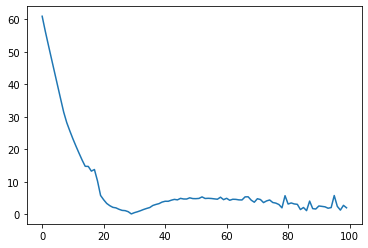

In [66]:
plt.plot(checkpoint['loss'].values)

In [67]:
#save last checkpoint
last_ckp = checkpoint.iloc[-1]
torch.save(last_ckp, 'lstm_ckps/ckp_{}.pth'.format(last_ckp['epoch']))

In [77]:
#re-define lstm model
lstm = LSTM(input_size, hidden_size, num_layer, output_size).double()
lstm

LSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [78]:
#re-define optimizer as Adam with reducing learning rate to 0.00001
optimizer = torch.optim.Adam(lstm.parameters(), lr= 0.00001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)

In [79]:
#load checkpoint
resume_ckp = torch.load('lstm_ckps/ckp_{}.pth'.format(last_ckp['epoch']))
resume_ckp

epoch                                                       100
loss          tensor(1.9644, dtype=torch.float64, requires_g...
valid_loss    tensor(10.0748, dtype=torch.float64, requires_...
param         {'lstm.weight_ih_l0': [[tensor(0.1750, dtype=t...
optim         {'state': {0: {'step': 81200, 'exp_avg': tenso...
Name: 99, dtype: object

In [80]:
#load state to the model
lstm.load_state_dict(resume_ckp['param'])
#load state to the optimizer
optimizer.load_state_dict(resume_ckp['optim'])

In [81]:
resume_epoch = resume_ckp['epoch']
resume_epoch

100

In [82]:
end_epoch = resume_epoch+num_epoch
end_epoch

200

In [83]:
%%time
#continue training more epoch with lower learing rate 
train_hist = fit_lstm(X_train_data, y_train_data, X_valid_data, y_valid_data,
                      num_layer, batch_size, hidden_size,
                      lstm, loss_fn, optimizer,
                      num_epoch, start_epoch=resume_epoch)

Epoch: [101/200]		 Loss: 2.1570		Validation Loss: 10.4757
Epoch: [102/200]		 Loss: 2.4252		Validation Loss: 10.3161
Epoch: [103/200]		 Loss: 0.6518		Validation Loss: 11.4442
Epoch: [104/200]		 Loss: 0.4573		Validation Loss: 11.0273
Epoch: [105/200]		 Loss: 1.7801		Validation Loss: 4.3767
Epoch: [106/200]		 Loss: 1.1887		Validation Loss: 10.2147
Epoch: [107/200]		 Loss: 0.3276		Validation Loss: 7.7738
Epoch: [108/200]		 Loss: 1.1037		Validation Loss: 10.0954
Epoch: [109/200]		 Loss: 7.6551		Validation Loss: 9.8851
Epoch: [110/200]		 Loss: 3.6519		Validation Loss: 9.7343
Epoch: [111/200]		 Loss: 1.3580		Validation Loss: 9.4642
Epoch: [112/200]		 Loss: 1.2033		Validation Loss: 8.4728
Epoch: [113/200]		 Loss: 0.6338		Validation Loss: 7.0571
Epoch: [114/200]		 Loss: 4.5583		Validation Loss: 9.4498
Epoch: [115/200]		 Loss: 1.8189		Validation Loss: 8.6313
Epoch: [116/200]		 Loss: 1.9495		Validation Loss: 10.2000
Epoch: [117/200]		 Loss: 2.0806		Validation Loss: 9.5943
Epoch: [118/200]		 Loss:

In [110]:
checkpoint = pd.DataFrame(train_hist)
checkpoint.iloc[-1]

epoch                                                       200
loss          tensor(1.2383, dtype=torch.float64, grad_fn=<L...
valid_loss    tensor(11.0128, dtype=torch.float64, grad_fn=<...
param         {'lstm.weight_ih_l0': [[tensor(0.3673, dtype=t...
optim         {'state': {0: {'step': 162400, 'exp_avg': tens...
Name: 99, dtype: object

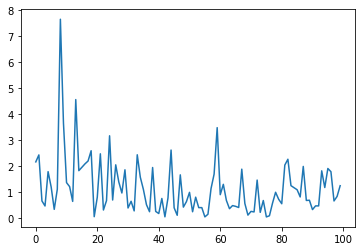

In [112]:
plt.plot(checkpoint['loss'])

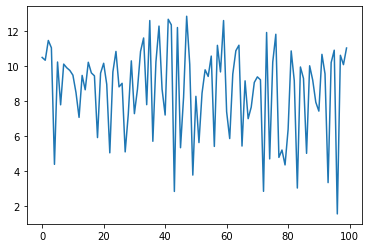

In [111]:
plt.plot(checkpoint['valid_loss'])

In [104]:
last_ckp = checkpoint.iloc[-1]
torch.save(last_ckp, 'lstm_ckps/ckp_{}.pth'.format(last_ckp['epoch']))

In [ ]:
#re-train again with lower training rate
lstm = LSTM(input_size, hidden_size, num_layer, output_size).double()
optimizer = torch.optim.Adam(lstm.parameters(), lr= 0.000001)

In [ ]:
def Min_Loss(loss_series):
    min_loss = loss_series[0].item()
    min_idx = 0
    for idx in range(len(loss_series)):
        if loss_series[idx].item() < min_loss:
            min_loss = loss_series[idx].item()
            min_idx = idx
    return (min_loss, min_idx)

In [ ]:
best_valid_ckp = new_ckp.iloc[Min_Loss(new_ckp['valid_loss'])[-1]]
best_valid_ckp

In [ ]:
torch.save(best_valid_ckp, 'lstm_ckps/best_valid.pth')

In [ ]:
best_train_ckp = new_ckp.iloc[Min_Loss(new_ckp['loss'])[-1]]
best_train_ckp

In [ ]:
torch.save(best_train_ckp, 'lstm_ckps/best_train.pth')

In [ ]:
last_ckp = new_ckp.iloc[-1]
last_ckp

In [ ]:
torch.save(last_ckp, 'lstm_ckps/ckp_{}.pth'.format(last_ckp['epoch']))

In [ ]:
#model testing preprocess
X_test_data = []
y_test_data = []
for i in range(timestep, len(X_test)):
    X_test_data.append(X_test[i-timestep:i])
    y_test_data.append(y_test[i])


# test_data
X_test_data = torch.DoubleTensor(X_test_data)
y_test_data = torch.DoubleTensor(y_test_data)

In [ ]:
#load train model
lstm = LSTM(input_size, hidden_size, num_layer, output_size).double()
train_ckp = torch.load('lstm_ckps/ckp_100.pth')
lstm.load_state_dict(train_ckp['param'])

#train prediction
state_in = (torch.zeros(num_layer, batch_size, hidden_size).double(),
            torch.zeros(num_layer, batch_size, hidden_size).double()
           )

train_pred = []

#shift data
for i in range(timestep):
    train_pred.append(None)

for i in range(X_train_data.size(0)):
    inputs = X_train_data[i].view(1,timestep,1)
    #forward propagation
    output, _ = lstm.forward(inputs.double(), state_in)
    train_pred.append(output.item())
    
#shift data
for i in range(timestep):
    train_pred.append(None)
    
for i in range(X_valid_data.size(0)):
    inputs = X_valid_data[i].view(1,timestep,1)
    #forward propagation
    output, _ = lstm.forward(inputs.double(), state_in)
    train_pred.append(output.item())
    
#shift data
for i in range(timestep):
    train_pred.append(None)
    
for i in range(X_test_data.size(0)):
    inputs = X_test_data[i].view(1,timestep,1)
    #forward propagation
    output, _ = lstm.forward(inputs.double(), state_in)
    train_pred.append(output.item())

In [ ]:
#inverse transform
#train_pred = list(y_scaler.inverse_transform(train_pred))

In [ ]:
# #shift data
# for i in range(timestep):
#     train_pred.insert(0, None)

In [ ]:
plt.plot(train_pred)
plt.plot(X)